# Ideal Diode Example

The simplest way to model a solar cell is as an **ideal diode**, described by the following equation:
$$J(V,T) = J_L+J_0(\exp{\frac{qV}{nkT}}-1)$$
where $k=8.61733\times 10^{-5}$ eV/K is Boltzmann's constant, by convention $J_L$ (the light current) is negative and $J_0$ (the saturation current) is positive but strongly dependent on temperature, a dependence we can approximate as:
$$J_0 \approx B'T^{3/n}\exp{\frac{-E_{g0}}{nkT}}$$
We'll use the silicon zero-temperature bandgap, $E_{g0}=1.2$ eV, meaning we just need to fit for $B'$ in this equation.
$J_L$ is typically directly proportional to light intensity, which we will treat as fixed for this example, leaving us with two parameters to fit for: $B'$ and the ideality factor $n$.

In [1]:
import numpy as np
import sys
import math
import pandas as pd
sys.path.append('../../')
import bayesim.model as bym
import bayesim.params as byp
import deepdish as dd

## List the parameters
First, we list our fitting parameters.

In [2]:
pl = byp.Param_list()
pl.add_fit_param(name='Bp',val_range=[10,1000],spacing='log',length=20,units='arb.')
pl.add_fit_param(name='n',val_range=[1,2],length=20, min_width=0.01)

Setting min_width automatically for Bp.


We can inspect the `Param_list` object and see what kind of information is inside...

In [3]:
print(pl)

{
    "fit_params": [
        {
            "units": "arb.", 
            "name": "Bp", 
            "spacing": "log", 
            "val_range": "[10, 1000]", 
            "vals": "[  11.22    14.125   17.783   22.387   28.184   35.481   44.67    56.2...", 
            "length": 20, 
            "edges": "[   10.       12.589    15.849    19.953    25.119    31.623    39.811...", 
            "min_width": 1.023292992280754, 
            "tolerance": 1.0023052380778996
        }, 
        {
            "units": "unitless", 
            "name": "n", 
            "tol_digits": 3, 
            "spacing": "linear", 
            "val_range": "[1, 2]", 
            "vals": "[1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475,...", 
            "length": 20, 
            "edges": "[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6...", 
            "min_width": 0.01, 
            "tolerance": 0.001
        }
    ], 
    "ec_x_name": null, 
    "ecs": [], 


Note that there are both `edges` and `vals` computed - the `vals` will be the values at which computations will be done, while `edges` will be the edges of the grid, used in subdivision steps later on.

Finally, we define the measurement conditions and output variable. We won't be varying light intensity here, so we only need voltage and temperature. We also set voltage as the parameter to be plotted on the x-axis when visualizing data.

In [4]:
pl.add_ec(name='V', units='V', is_x=True) # this will be on the x-axis when we plot data
pl.add_ec(name='T', units='K', tolerance=0.1)
pl.add_output(name='J', units='A/cm^2')

In [5]:
print(pl)

{
    "fit_params": [
        {
            "units": "arb.", 
            "name": "Bp", 
            "spacing": "log", 
            "val_range": "[10, 1000]", 
            "vals": "[  11.22    14.125   17.783   22.387   28.184   35.481   44.67    56.2...", 
            "length": 20, 
            "edges": "[   10.       12.589    15.849    19.953    25.119    31.623    39.811...", 
            "min_width": 1.023292992280754, 
            "tolerance": 1.0023052380778996
        }, 
        {
            "units": "unitless", 
            "name": "n", 
            "tol_digits": 3, 
            "spacing": "linear", 
            "val_range": "[1, 2]", 
            "vals": "[1.025, 1.075, 1.125, 1.175, 1.225, 1.275, 1.325, 1.375, 1.425, 1.475,...", 
            "length": 20, 
            "edges": "[1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6...", 
            "min_width": 0.01, 
            "tolerance": 0.001
        }
    ], 
    "ec_x_name": "V", 
    "ecs": [
    

## Initialize the model
Now we're ready to initialize our bayesim Model object.

In [6]:
m = bym.Model(params=pl)

By default, a uniform probability distribution is created...

In [7]:
m.probs.points.head(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob
0,11.22,10.0,12.589,1.025,1.00,1.05,0.0025
1,11.22,10.0,12.589,1.075,1.05,1.10,0.0025
2,11.22,10.0,12.589,1.125,1.10,1.15,0.0025
3,11.22,10.0,12.589,1.175,1.15,1.20,0.0025
4,11.22,10.0,12.589,1.225,1.20,1.25,0.0025
5,11.22,10.0,12.589,1.275,1.25,1.30,0.0025
6,11.22,10.0,12.589,1.325,1.30,1.35,0.0025
7,11.22,10.0,12.589,1.375,1.35,1.40,0.0025
8,11.22,10.0,12.589,1.425,1.40,1.45,0.0025
9,11.22,10.0,12.589,1.475,1.45,1.50,0.0025


## Attach experimental data
This is the next step that needs to be done before adding the model as it will use the experimental conditions we enumerate here to compute simulated outputs. For our "experimental" data here, we'll actually just simulate some ideal diodes so that we can directly see how good the Bayesian approach is at recovering true underlying parameters.

We'll use $n=1.36$ and $B'=258$ as our "true" parameters. (I have no idea what "realistic" values for $B'$ would be...)

Here we generate and save the data as well as plot it.

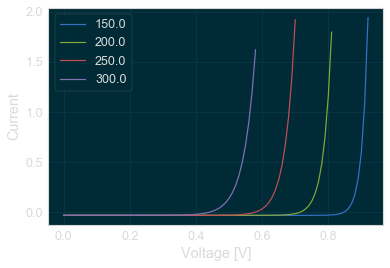

In [8]:
def compute_ID(ec,params):
    J_L = -0.03 # treat as fixed for now
    V = ec['V']
    T = ec['T']
    V_th = 8.61733e-5 * T # thermal voltage, kT/q
    n = params['n']
    Bp = params['Bp']
    J0 = Bp*T**(3/n)*math.exp(-1.2/V_th/n)
    return J_L + J0*(math.exp(V/V_th/n)-1)

V = np.arange(0,1.0,0.01)
T = [float(t) for t in np.arange(150,301,50)]
#V = np.arange(0,1.0,0.1)
#T = [200.0,300.0]
params = {'n':1.36,'Bp':258}

data = []
for t in T:
    J0 = compute_ID({'V':V[0],'T':t},params)
    for v in V:
        J = compute_ID({'V':v,'T':t},params)
        if abs(J)>0.1:
            err = 0.05*abs(J)
        else:
            err = 0.005
        # check for "compliance"
        if not J > 2.0:
            data.append([v,t,J,err])
        
data = pd.DataFrame.from_records(data=data,columns=['V','T','J','error'])
dd.io.save('obs_data.h5',data)

import matplotlib.pyplot as plt
%matplotlib inline
leg = []
for i in range(len(T)):
    curve = data[data['T']==T[i]]
    plt.plot(curve['V'],curve['J'])
    leg.append(curve['T'].iloc[0])
#plt.ylim([-0.05,0.1])
plt.legend([str(t) for t in leg])
plt.xlabel('Voltage [V]')
plt.ylabel('Current')
plt.show()

Now that we've generated our "observations," we can attach them to `bayesim`. There are some options when we attach the observations, notably `keep_all` and `max_ec_x_step`. If `keep_all` is set to False, `attach_observations` will only import data points that differ from each other by more than 1% (this 1% threshold can be modified with the `thresh_dif_frac` option) in the output variable (J) along the defined x-axis variable (V). However, `max_ec_x_step` tells it to only skip a maximum of 0.2 V before saving a point even if it differs by <1% from the previous one.

Finally, we define the experimental error to be 0.0001 for all data points (one could also define errors at specific points by including an 'error' column in the file with the observed data).

In [9]:
m.attach_observations(obs_data_path='obs_data.h5', keep_all=False, max_ec_x_step=0.2, fixed_err=0.0001)

## Attach model
Now we add the function that gives the modeled data - in this case, the `compute_ID` function we just defined above.

In [10]:
m.attach_model(mode='function',func_name=compute_ID)
#m.attach_model(mode='file',fpath='model_data.h5')

When that function is called, `bayesim` also generates the full table of modeled data at all experimental conditions in the observed data we attached before. Check it out:

In [11]:
m.model_data.head()

,Bp,J,T,V,n
0,11.22,-0.03,150.0,0.0,1.025
1,11.22,-0.03,200.0,0.0,1.025
2,11.22,-0.03,250.0,0.0,1.025
3,11.22,-0.03,300.0,0.0,1.025
4,11.22,-0.03,150.0,0.2,1.025


We'll also compute the "model errors" - the difference in output variable (at a fixed set of experimental conditions) when one moves around the fitting parameter space. For each point, the likelihood will be calculated with a standard deviation equal to the maximum of the experimental error and the model error.

In [12]:
m.calc_model_errors()

In [13]:
m.model_data.sample(5)

,Bp,J,T,V,n,error
565,11.22,-0.004284,250.0,0.65,1.475,0.006658
9781,70.79,0.061906,200.0,0.78,1.275,0.026200
19873,446.70,0.081479,150.0,0.81,1.825,0.028849
10768,89.13,-0.024082,250.0,0.61,1.125,0.002994
10071,70.79,0.010773,200.0,0.73,1.525,0.010894


## Drop that Bayes!
### First Bayes
We're ready to do our Bayesian inference! The `run` function has many options one can set but can be called with no arguments to run in the default way, which is the following:

A threshold probability concentration is defined by an amount of probability mass (`th_pm`, defaults to 0.8) and a fraction of the fitting parameter space volume (`th_pv`, defaults to 0.05). `bayesim` chooses observation points randomly for Bayesian updates until at least `th_pm` of the probability resides in at most `th_pv` of the parameter space.

However, depending on the thresholds set, data sampling and other factors, this threshold could potentially take very few observation points to reach, meaning we will inevitably be sampling our experimental conditions unevenly. To address this, a parameter `min_num_pts` is defined (with a default value of 0.7 * the number of observed data points). The procedure just described is repeated until that number of points has been used, and the resulting probability distributions from each cycle are averaged together to produce the final result.

In [14]:
m.run()

Did a total of 36 runs to use a total of 41 observations.

An average of 226 / 400 probability points used model errors (rather than experimental errors) during this run.


We can visualize the distribution and add markers for the real values to compare...

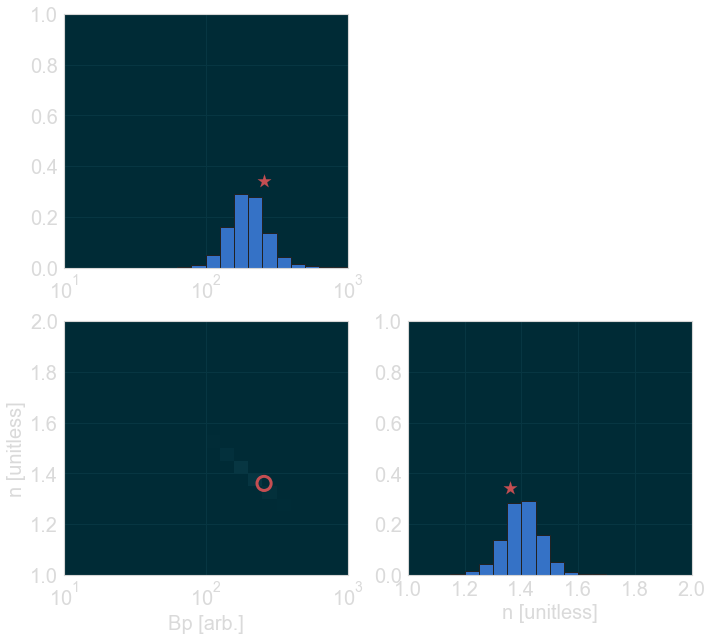

In [15]:
m.visualize_probs(true_vals=params)

We can also plot the simulated data corresponding to the most probable points in parameter space and compare to the observed data at the same conditions.

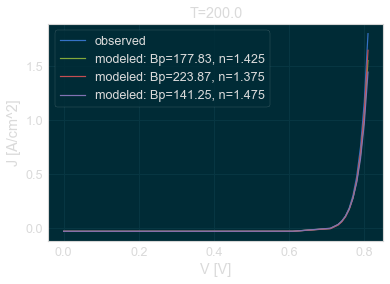

In [16]:
m.comparison_plot(num_param_pts=3)

Not too bad. We can also of course look at the probabilities directly...

In [17]:
m.top_probs(5)

,prob,Bp,n,Bp_min,Bp_max,n_min,n_max
248,0.283207,177.83,1.425,158.49,199.53,1.40,1.45
267,0.273689,223.87,1.375,199.53,251.19,1.35,1.40
229,0.151829,141.25,1.475,125.89,158.49,1.45,1.50
286,0.129522,281.84,1.325,251.19,316.23,1.30,1.35
210,0.045317,112.20,1.525,100.00,125.89,1.50,1.55


### Let's subdivide!
Again we'll use the default options, which will subdivide all grid boxes with probability > 0.001 as well as any immediately adjacent boxes. It will discard any boxes with probability < 0.001. This threshold can be modified with the `threshold_prob` argument.

In [18]:
m.subdivide()

22 box(es) with probability > 0.001 and 26 neighboring boxes subdivided!
Overwriting metadata for fitting parameter Bp with new info.
Overwriting metadata for fitting parameter n with new info.
New model points to simulate are saved in the file new_sim_points_1.h5.


Let's take a look at the grid.

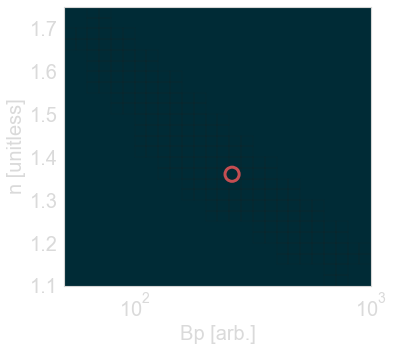

In [19]:
m.visualize_grid(true_vals=params)

### Compute and attach new model data
We've added new model points to the grid so we have to compute the modeled values and attach that data.

In [20]:
new_sims = dd.io.load('new_sim_points_1.h5')

In [21]:
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_1.h5',new_sim_data)

In [22]:
m.attach_model(mode='file', fpath='new_sim_data_1.h5', calc_errors=True)

### Second Bayes!
Let's do it again!

In [23]:
m.run()
#m.run(force_exp_err=True,min_num_pts=1)

Did a total of 24 runs to use a total of 41 observations.

An average of 121 / 192 probability points used model errors (rather than experimental errors) during this run.


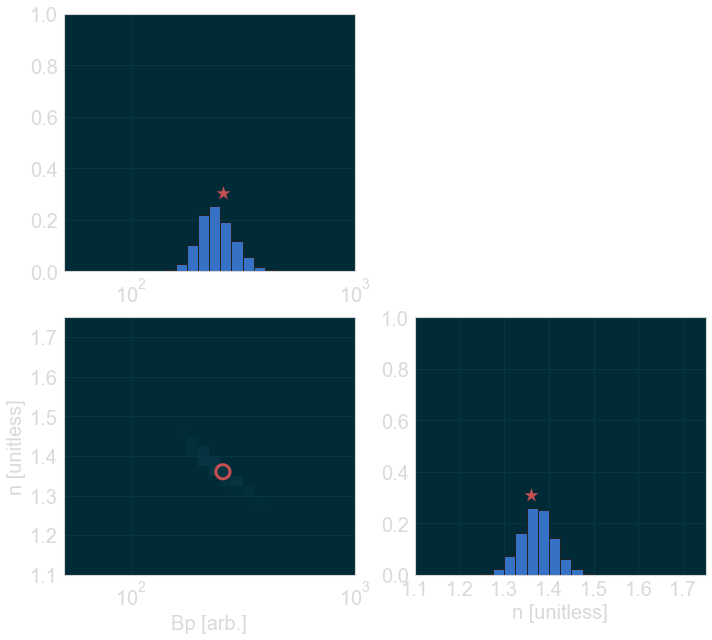

In [24]:
m.visualize_probs(true_vals=params)

Note that the parameter ranges have narrowed slightly...

In [25]:
m.top_probs(10)

,prob,Bp,n,Bp_min,Bp_max,n_min,n_max
110,0.129816,237.14,1.3625,223.87,251.19,1.350,1.375
120,0.128891,266.07,1.3625,251.19,281.84,1.350,1.375
101,0.126971,211.35,1.3875,199.53,223.87,1.375,1.400
111,0.125902,237.14,1.3875,223.87,251.19,1.375,1.400
127,0.098823,298.54,1.3375,281.84,316.23,1.325,1.350
102,0.091989,211.35,1.4125,199.53,223.87,1.400,1.425
119,0.062496,266.07,1.3375,251.19,281.84,1.325,1.350
136,0.053416,334.97,1.3125,316.23,354.82,1.300,1.325
91,0.052500,188.37,1.4375,177.83,199.53,1.425,1.450
90,0.050091,188.37,1.4125,177.83,199.53,1.400,1.425


Here's a cool trick with the `comparison_plot` function - we can choose more of the other experimental conditions to plot at!

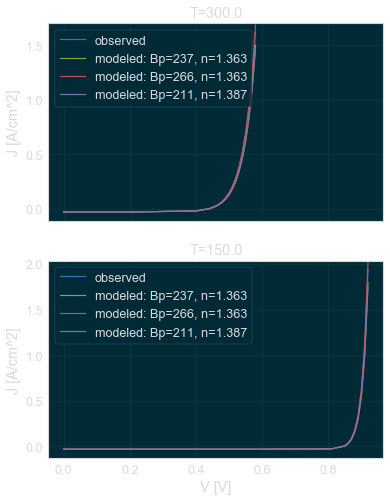

In [26]:
m.comparison_plot(num_param_pts=3, num_ecs=2)

In [27]:
m.subdivide()

17 box(es) with probability > 0.001 and 23 neighboring boxes subdivided!
Overwriting metadata for fitting parameter Bp with new info.
Overwriting metadata for fitting parameter n with new info.
New model points to simulate are saved in the file new_sim_points_2.h5.


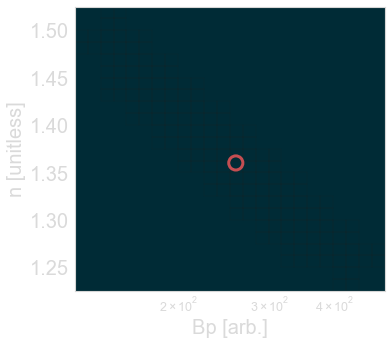

In [28]:
m.visualize_grid(true_vals=params)

In [29]:
m.probs.points.sample(10)

,Bp,Bp_min,Bp_max,n,n_min,n_max,prob
119,325.47,316.23,334.97,1.2937,1.2875,1.3000,8.536836e-04
88,258.52,251.19,266.07,1.3563,1.3500,1.3625,3.226721e-02
126,344.75,334.97,354.82,1.2813,1.2750,1.2875,8.536836e-04
153,434.02,421.71,446.70,1.2687,1.2625,1.2750,1.044718e-03
94,273.84,266.07,281.84,1.3313,1.3250,1.3375,1.564565e-02
115,307.26,298.54,316.23,1.3687,1.3625,1.3750,9.966644e-07
63,217.52,211.35,223.87,1.3937,1.3875,1.4000,3.178674e-02
65,217.52,211.35,223.87,1.4187,1.4125,1.4250,2.302901e-02
12,153.99,149.62,158.49,1.4312,1.4250,1.4375,9.093830e-12
149,409.74,398.11,421.71,1.2937,1.2875,1.3000,1.055375e-06


In [30]:
new_sims = dd.io.load('new_sim_points_2.h5')
data = []
for sim in new_sims.iterrows():
    v = sim[1]['V']
    t = sim[1]['T']
    this_pt = [v,t,compute_ID({'V':v,'T':t},sim[1])]
    this_pt.extend([sim[1][n] for n in m.fit_param_names()])
    data.append(this_pt)
columns = ['V','T','J']
columns.extend(m.fit_param_names())
new_sim_data = pd.DataFrame.from_records(data=data,columns=columns)
dd.io.save('new_sim_data_2.h5',new_sim_data)
m.attach_model(mode='file', fpath='new_sim_data_2.h5', calc_errors=True)

In [31]:
m.run()

Did a total of 30 runs to use a total of 41 observations.

An average of 99 / 160 probability points used model errors (rather than experimental errors) during this run.


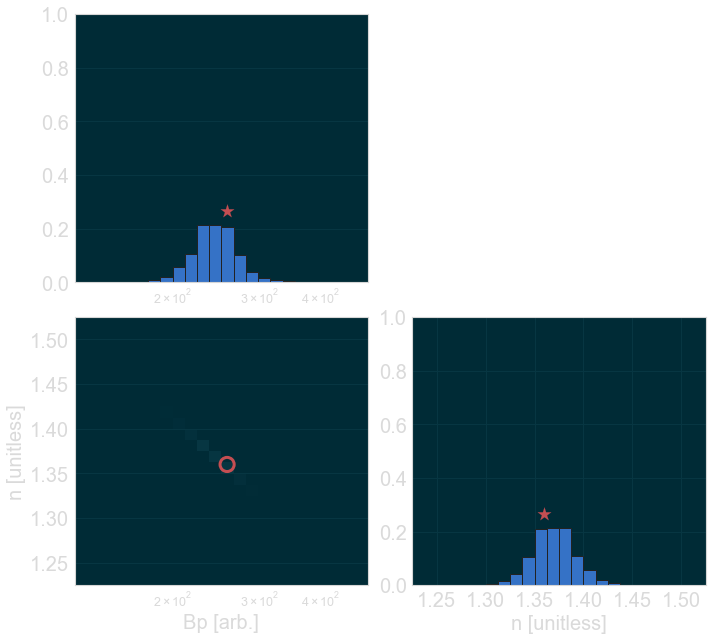

In [32]:
m.visualize_probs(true_vals=params)

In [33]:
m.top_probs(5)

,prob,Bp,n,Bp_min,Bp_max,n_min,n_max
72,0.212658,230.41,1.3813,223.87,237.14,1.3750,1.3875
79,0.210178,244.06,1.3687,237.14,251.19,1.3625,1.3750
88,0.203442,258.52,1.3563,251.19,266.07,1.3500,1.3625
63,0.106360,217.52,1.3937,211.35,223.87,1.3875,1.4000
95,0.096001,273.84,1.3438,266.07,281.84,1.3375,1.3500


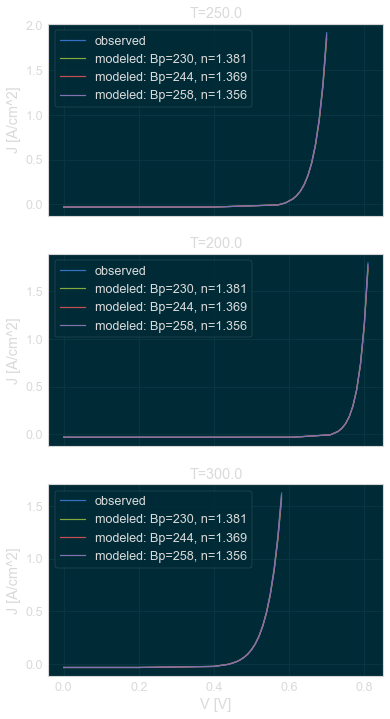

In [34]:
m.comparison_plot(num_param_pts=3, num_ecs=3)